# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Create-Timeseries-of-Daily-Flight-Counts" data-toc-modified-id="Create-Timeseries-of-Daily-Flight-Counts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create Timeseries of Daily Flight Counts</a></div><div class="lev2 toc-item"><a href="#Create-interactive-plot-with-plotly/cufflinks" data-toc-modified-id="Create-interactive-plot-with-plotly/cufflinks-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create interactive plot with plotly/cufflinks</a></div><div class="lev1 toc-item"><a href="#Regress-out-effect-from-&quot;DAY-OF-WEEK&quot;" data-toc-modified-id="Regress-out-effect-from-&quot;DAY-OF-WEEK&quot;-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regress out effect from "DAY OF WEEK"</a></div><div class="lev2 toc-item"><a href="#Plot-residuals-after-&quot;weekday&quot;-regression" data-toc-modified-id="Plot-residuals-after-&quot;weekday&quot;-regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot residuals after "weekday" regression</a></div><div class="lev2 toc-item"><a href="#Get-&quot;Lagged&quot;-residual" data-toc-modified-id="Get-&quot;Lagged&quot;-residual-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Get "Lagged" residual</a></div><div class="lev1 toc-item"><a href="#Try-overlaying-the-annual-plots" data-toc-modified-id="Try-overlaying-the-annual-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Try overlaying the annual plots</a></div>

In [1]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import plotly.plotly as py
import calendar

from datetime import datetime
from pprint import pprint
from IPython.display import display

import cufflinks as cf
cf.set_config_file(theme='ggplot')

import util

# limit output to avoid cluttering screen
pd.options.display.max_rows = 20

In [3]:
cf.get_config_file()

{u'colorscale': u'dflt',
 u'datagen_mode': u'stocks',
 u'dimensions': None,
 u'offline': False,
 u'offline_link_text': u'Export to plot.ly',
 u'offline_show_link': True,
 u'offline_url': u'',
 u'sharing': u'public',
 u'theme': u'ggplot'}

In [4]:
# name of output files to prepend with
outfile = 'regression-analysis-3years_'

# Load data

Load the **airport data**, as well as the **lookup-table* I created [here](http://takwatanabe.me/airtraffic/create_lookup_table.html).


In [12]:
df_data = util.load_airport_data_3years()

 ... load dataframe from 2013-11.zip 
 ... load dataframe from 2013-12.zip 
 ... load dataframe from 2014-01.zip 
 ... load dataframe from 2014-02.zip 
 ... load dataframe from 2014-03.zip 
 ... load dataframe from 2014-04.zip 
 ... load dataframe from 2014-05.zip 
 ... load dataframe from 2014-06.zip 
 ... load dataframe from 2014-07.zip 
 ... load dataframe from 2014-08.zip 
 ... load dataframe from 2014-09.zip 
 ... load dataframe from 2014-10.zip 
 ... load dataframe from 2014-11.zip 
 ... load dataframe from 2014-12.zip 
 ... load dataframe from 2015-01.zip 
 ... load dataframe from 2015-02.zip 
 ... load dataframe from 2015-03.zip 
 ... load dataframe from 2015-04.zip 
 ... load dataframe from 2015-05.zip 
 ... load dataframe from 2015-06.zip 
 ... load dataframe from 2015-07.zip 
 ... load dataframe from 2015-08.zip 
 ... load dataframe from 2015-09.zip 
 ... load dataframe from 2015-10.zip 
 ... load dataframe from 2015-11.zip 
 ... load dataframe from 2015-12.zip 
 ... load da

In [13]:
hash_dayofweek = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
df_data['DAY_OF_WEEK'] = df_data['DAY_OF_WEEK'].map(lambda key: hash_dayofweek[key])
df_lookup = pd.read_csv('df_lookup.csv') # lookup table for the AIRPORT_ID above

# create hash-table to convert Airport "Code" to "City_State" and airport names
dhash_lookup = df_lookup.set_index('Code')['City_State'].to_dict()
hash_airport = df_lookup.set_index('Code')['Airport'].to_dict()

# Create Timeseries of Daily Flight Counts

- Here, I would like to analyze the trend in the **total daily flights** in the United States.

- To this end, we'll first construct a [Pandas TimeSeries](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) DataFrame containing the daily Flight-count information.

In [14]:
# create a column containing "YEAR-MONTH-DAY"
df_data['time'] = ( df_data['YEAR'].astype(str) + '-' 
                  + df_data['MONTH'].astype(str) + '-' 
                  + df_data['DAY_OF_MONTH'].astype(str))

In [17]:
# create time-series of airtraffic counts
ts_flightcounts = pd.DataFrame(df_data['time'].value_counts()).rename(columns={'time':'counts'})
ts_flightcounts.index = ts_flightcounts.index.to_datetime()
ts_flightcounts.sort_index(inplace=True) # need to sort by date

# explicitly add extra date-info as dataframe columns (to apply `groupby` later)
ts_flightcounts['day']= ts_flightcounts.index.day
ts_flightcounts['month']= ts_flightcounts.index.month
ts_flightcounts['day_of_week'] = ts_flightcounts.index.dayofweek

# `dayofweek` uses encoding Monday=0 ... Sunday=6...make this explicit
ts_flightcounts['day_of_week'] = ts_flightcounts['day_of_week'].map({0:'Mon',
                                                                     1:'Tue',
                                                                     2:'Wed',
                                                                     3:'Thu',
                                                                     4:'Fri',
                                                                     5:'Sat',
                                                                     6:'Sun'}).astype(str)

ts_flightcounts.head()

,counts,day,month,day_of_week
2013-11-01,18215,1,11,Fri
2013-11-02,13813,2,11,Sat
2013-11-03,17031,3,11,Sun
2013-11-04,18039,4,11,Mon
2013-11-05,17259,5,11,Tue


In [18]:
# create hover_text object for plotly
hover_text= (
    ts_flightcounts['month'].astype(str) 
    + '/' 
    + ts_flightcounts['day'].astype(str)
    + ' (' + ts_flightcounts['day_of_week'] + ')'
).tolist()
print hover_text[:5]

['11/1 (Fri)', '11/2 (Sat)', '11/3 (Sun)', '11/4 (Mon)', '11/5 (Tue)']


## Create interactive plot with plotly/cufflinks

- I am a huge fan of [plotly](http://plot.ly/python/)...brings the distance between the data and user closer together :)


In [20]:
# see https://plot.ly/pandas/line-charts/
plt_options = dict(text=hover_text,color='pink')
title = 'Daily Airflight Counts in the US between 11/1/2013 - 10/31/2016'
title+= '<br>(hover over plot for dates; left-click to zoom)'

ts_flightcounts.iplot(y='counts',
                      filename=outfile+'plot_flightcounts',
                      title=title,
                      **plt_options)

- From the above time-series plot, we can see that the trend in the Flight-counts looks to be obscured by the effect from the ``day_of_week``



# Regress out effect from "DAY OF WEEK"

- Apply linear regression using the "Day of the week" as the regressor.

- By studying the residual from this regression, we hope to see more salient pattern once the dominant effect of "day-of-week" is removed

In [31]:
import statsmodels.formula.api as smf
mod = smf.ols(formula = 'counts ~ C(day_of_week) - 1',data=ts_flightcounts).fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     212.7
Date:                Tue, 10 Jan 2017   Prob (F-statistic):          1.59e-179
Time:                        16:38:42   Log-Likelihood:                -9081.9
No. Observations:                1096   AIC:                         1.818e+04
Df Residuals:                    1089   BIC:                         1.821e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
C(day_of_week)[Fri]  1.652e+04     76.905    214.751      0.000      1.64e+04  1.67e+04
C(day_of_week)[Mon]  1.653e+04     76.905    214.941      0.000      1.64e+04  1.67e+04
C(day_of_week)[Sat]  1.341e+04     76.905    174.351      0.000      1.33e+04  1.36e+04
C(day_of_week)[Sun]   1.56e+04     76.905    202.900      0.000      1.55e+04  1.58e+04
C(day_of_week)[Thu]  1.646e+04     77.151    213.367      0.000      1.63e+04  1.66e+04
C(day_of_week)[Tue]  1.612e+04     77.151    208.939      0.000       1.6e+04  1.63e+04
C(day_of_week)[Wed]  1.627e+04     77.151    210.946      0.000      1.61e+04  1.64e+04
==============================================================================
Omnibus:                      334.890   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1830.024
Skew:                          -1.299   Prob(JB):                         0.00
Kurtosis:                       8.772   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot residuals after "weekday" regression

In [32]:
# add residual information
ts_flightcounts['residual'] = mod.resid

title = 'Residual Airflight Counts in the US <br>(`day_of_week` as regressors)'
ts_flightcounts.iplot(y=['residual'],
                      filename=outfile+'plot_resid',
                      text=hover_text,
                      title=title)

## Get "Lagged" residual

- let's take this a step further, and compute and plot the "lagged" residual plot

- this is given by: ``resid_lag[t] = resid[t+1] - resid[t]``

In [33]:
# also add "lagged" residual information
ts_flightcounts['resid_lag'] = \
    ts_flightcounts['residual'].shift(1) - ts_flightcounts['residual']
    
title = 'Lagged Residual Plot of Airflight Counts in the US (left click to zoom)'
title+= '<br>("day-of-week" used as regressors; shaded region = +/-1.5 std-dev)'

annotations = {
    datetime(2015,11,26):'Thanksgiving',
    datetime(2015,12,24):'Christmas Eve',
    datetime(2015,12,31):'New Years',
    datetime(2016, 2, 7):'??? Something happen ???',
    datetime(2016, 5,29):'Memorials Day',
    datetime(2016, 7, 3):'Independence Day',
    datetime(2016, 9, 4):'Labor Day',
}

std_ = ts_flightcounts['resid_lag'].std()

In [34]:
ts_flightcounts['resid_lag'].iplot(
    filename=outfile+'plot_resid_lag',
    annotations=annotations,
    #hspan=[(-1.5*std_,1.5*std_)],
    hspan = dict(y0=-1.5*std_,y1=1.5*std_,opacity=0.2,color='teal',fill=True),
    text=hover_text,
    title=title)

# Try overlaying the annual plots

In [35]:
# --- add period info ---
display(ts_flightcounts.head())
ts_flightcounts['period'] = np.nan
#ts_flightcounts.isnull().sum()
ts_flightcounts.loc[datetime(2013,11,1):datetime(2014,10,31), 'period'] = 'period1'
ts_flightcounts.loc[datetime(2014,11,1):datetime(2015,10,31), 'period'] = 'period2'
ts_flightcounts.loc[datetime(2015,11,1):datetime(2016,10,31), 'period'] = 'period3'

display(ts_flightcounts.head())
assert ts_flightcounts['period'].isnull().sum() == 0

,counts,day,month,day_of_week,residual,resid_lag
2013-11-01,18215,1,11,Fri,1699.554140,NaN
2013-11-02,13813,2,11,Sat,404.471338,1295.082803
2013-11-03,17031,3,11,Sun,1426.910828,-1022.439490
2013-11-04,18039,4,11,Mon,1508.917197,-82.006369
2013-11-05,17259,5,11,Tue,1139.108974,369.808223


,counts,day,month,day_of_week,residual,resid_lag,period
2013-11-01,18215,1,11,Fri,1699.554140,NaN,period1
2013-11-02,13813,2,11,Sat,404.471338,1295.082803,period1
2013-11-03,17031,3,11,Sun,1426.910828,-1022.439490,period1
2013-11-04,18039,4,11,Mon,1508.917197,-82.006369,period1
2013-11-05,17259,5,11,Tue,1139.108974,369.808223,period1


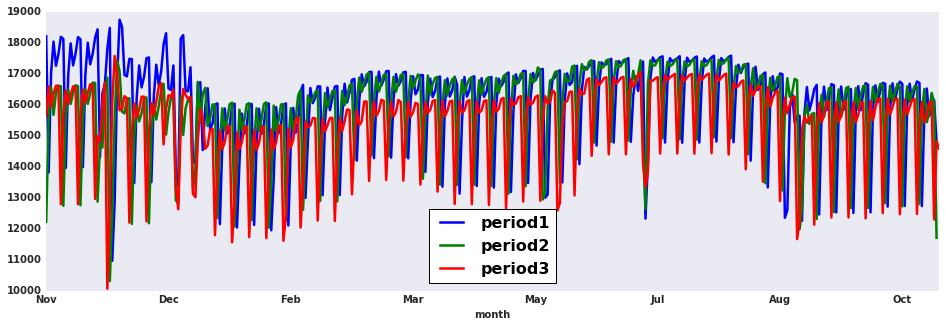

In [44]:
#http://stackoverflow.com/questions/37596714/compare-multiple-year-data-on-a-single-plot-python
#http://man7.org/linux/man-pages/man3/strftime.3.html
ts_flightcounts['month'] = ts_flightcounts.index.to_series().dt.strftime('%b')
util.sns_figure(figsize=(16,5))
ts_flightcounts.query('period == "period1"').plot(x='month',y='counts',label='period1',ax=plt.gca())
ts_flightcounts.query('period == "period2"').plot(x='month',y='counts',label='period2',ax=plt.gca())
ts_flightcounts.query('period == "period3"').plot(x='month',y='counts',label='period3',ax=plt.gca())

In [42]:
ts_flightcounts.query('period == "period1"').iplot(y='counts')